# FlowPic CNN-Model
### This notebook run the non-vpn datas in weighted-class with CNN-Model


~~~~


 ~~~~
 Tests-results:
 ~~~~
##### win-60: 0.978%
##### win-60 25% overlap: 0.989%
##### win-60 75% overlap: 0.992%
##### win-30: 0.981%
##### win-10: 0.994%

~~~~~

~~~~
cnn-model parameters:
~~~~
###### 1. Conv_layer= (10, kernel=(10, 10),strides= 5)
###### 2. MaxPooling2D = (2, 2)
###### 3. Conv_layer= (20, kernel=(10, 10),strides= 5)
###### 4. Dropout = 0.25
###### 5. MaxPooling2D = (2, 2)
###### 6. Flatten
###### 7. Dense 64
###### 8. Dropout = 0.5
###### 9. Output Dense = num_classes


~~~~

#### Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import top_k_categorical_accuracy, Precision, Recall
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from datetime import timedelta
import os

#### functions

In [2]:
class CNNDatasetEvaluator:
    def __init__(self, height=1500, width=1500, channels=1):
        """
        Initialize the evaluator with default image dimensions
        
        Parameters:
        - height: Image height
        - width: Image width
        - channels: Number of image channels
        """
        self.height = height
        self.width = width
        self.channels = channels
        self.input_shape = (self.channels, self.height, self.width)
        
        # Default model parameters
        self._conv_layers = [(10, (10, 10), 5), (20, (10, 10), 5)]  # Convolutional layers
        self._dropout_rates = [0.25, 0.5]  # Dropout rates
        self._dense_layers = [64]  # Dense layers

    def compute_class_weights(self, y_train):
        """
        Compute class weights for imbalanced datasets.
        
        Parameters:
        - y_train: Training labels (integer format, not one-hot encoded)
        
        Returns:
        - class_weights: Dictionary of class weights
        """
        # Convert one-hot encoded labels to integer format if necessary
        if len(y_train.shape) > 1 and y_train.shape[1] > 1:
            y_train = np.argmax(y_train, axis=1)
        
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        return dict(zip(classes, class_weights))
    
    def top_2_categorical_accuracy(self, y_true, y_pred):
        """Custom top-2 categorical accuracy metric"""
        return top_k_categorical_accuracy(y_true, y_pred, k=2)
    
    def build_model(self, num_classes):
        """
        Build CNN model with flexible architecture
        
        Parameters:
        - num_classes: Number of output classes
        """
        model = Sequential()
        
        # First convolutional layer
        model.add(Conv2D(self._conv_layers[0][0], 
                         kernel_size=self._conv_layers[0][1], 
                         strides=self._conv_layers[0][2], 
                         padding="same", 
                         data_format='channels_last', 
                         input_shape=self.input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last'))
        
        # Additional convolutional layers
        for filters, kernel_size, stride in self._conv_layers[1:]:
            model.add(Conv2D(filters, 
                             kernel_size=kernel_size, 
                             strides=stride, 
                             padding="same", 
                             data_format='channels_last'))
            model.add(Activation('relu'))
            model.add(Dropout(self._dropout_rates[0]))
            model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last'))
        
        # Flatten and dense layers
        model.add(Flatten())
        for neurons in self._dense_layers:
            model.add(Dense(neurons, activation='relu'))
            model.add(Dropout(self._dropout_rates[1]))
        
        # Output layer
        model.add(Dense(num_classes, activation='softmax'))
        
        return model
    
    def prepare_data(self, X, y, num_classes):
        """
        Prepare data for training
        
        Parameters:
        - X: Input features
        - y: Input labels
        - num_classes: Number of classes
        
        Returns:
        - Processed X and one-hot encoded y
        """
        # Expand dimensions if needed
        if len(X.shape) == 3:
            X = np.expand_dims(X, axis=1)
        elif len(X.shape) != 4:
            raise ValueError(f"Input data must be 3D or 4D, but got shape {X.shape}")
        
        # One-hot encode labels
        y_categorical = to_categorical(y, num_classes)
        
        return X, y_categorical
    
    def train_and_evaluate(self, X_train, y_train, X_val, y_val, X_test, y_test, 
                       class_names=None, 
                       batch_size=128, 
                       epochs=20, 
                       samples_per_epoch=10,
                       use_class_weights=False):
        """
        Train and evaluate the model on given datasets
        
        Parameters:
        - X_train, y_train: Training data
        - X_val, y_val: Validation data
        - X_test, y_test: Test data
        - class_names: Optional list of class names
        - batch_size: Training batch size
        - epochs: Number of training epochs
        - samples_per_epoch: Samples per epoch for generator
        - use_class_weights: Whether to compute and use class weights for imbalanced datasets
        
        Returns:
        - Dictionary with training results
        """
        # Determine number of classes
        num_classes = len(np.unique(y_train))
        
        # Prepare data
        X_train, y_train = self.prepare_data(X_train, y_train, num_classes)
        X_val, y_val = self.prepare_data(X_val, y_val, num_classes)
        X_test, y_test = self.prepare_data(X_test, y_test, num_classes)
        
        # Compute class weights if requested
        class_weights = None
        if use_class_weights:
            y_train_classes = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
            class_weights = self.compute_class_weights(y_train_classes)
        
        # Build model
        model = self.build_model(num_classes)
        
        # Compile model
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy', self.top_2_categorical_accuracy, Precision(), Recall()]
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-6
            ),
            TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)
        ]
        
        # Simple generator
        def generator(features, labels, batch_size):
            index = 0
            while True:
                index += batch_size
                if index >= len(features):
                    batch_features = np.append(features[index - batch_size:len(features)], 
                                               features[0:index - len(features)], axis=0)
                    batch_labels = np.append(labels[index - batch_size:len(features)], 
                                             labels[0:index - len(features)], axis=0)
                    index -= len(features)
                    yield batch_features, batch_labels
                else:
                    yield features[index - batch_size:index], labels[index - batch_size:index]

        def weighted_generator(features, labels, batch_size, class_weights):
            index = 0
            num_samples = len(features)
            while True:
                index += batch_size
                if index >= num_samples:
                    batch_features = np.append(features[index - batch_size:num_samples], 
                                               features[0:index - num_samples], axis=0)
                    batch_labels = np.append(labels[index - batch_size:num_samples], 
                                             labels[0:index - num_samples], axis=0)
                    index -= num_samples
                else:
                    batch_features = features[index - batch_size:index]
                    batch_labels = labels[index - batch_size:index]
                
                # Compute sample weights based on class weights
                sample_weights = np.array([class_weights[np.argmax(label)] for label in batch_labels])
                
                yield batch_features, batch_labels, sample_weights
        
        # Train model
        start_time = time.time()
        if use_class_weights:
            # Use the weighted generator
            train_gen = weighted_generator(X_train, y_train, batch_size, class_weights)
            history = model.fit(
                train_gen,
                epochs=epochs,
                steps_per_epoch=samples_per_epoch,
                verbose=1,
                callbacks=callbacks,
                validation_data=(X_val, y_val)
            )
        else:
        # Use the original generator
            train_gen = generator(X_train, y_train, batch_size)
            history = model.fit(
                train_gen,
                epochs=epochs,
                steps_per_epoch=samples_per_epoch,
                verbose=1,
                callbacks=callbacks,
                validation_data=(X_val, y_val)
            )
        
        # Calculate training time
        training_time = time.time() - start_time
        
        # Predictions
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        
        # Convert y_test and y_val from one-hot encoded to integer labels if necessary
        y_val_classes = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val
        y_test_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
        
        # Results
        results = {
            'training_time': timedelta(seconds=training_time),
            'val_classification_report': classification_report(
                y_val_classes, 
                y_val_pred_classes, 
                target_names=class_names
            ),
            'test_classification_report': classification_report(
                y_test_classes, 
                y_test_pred_classes, 
                target_names=class_names
            ),
            'val_accuracy': np.mean(y_val_pred_classes == y_val_classes),
            'test_accuracy': np.mean(y_test_pred_classes == y_test_classes),
            'history': history.history,
            'test_predictions': y_test_pred
        }
        
        return results
    
    # Getter and Setter methods for model parameters
    def get_conv_layers(self):
        """Get the convolutional layers configuration"""
        return self._conv_layers
    
    def set_conv_layers(self, conv_layers):
        """Set the convolutional layers configuration"""
        self._conv_layers = conv_layers
    
    def get_dropout_rates(self):
        """Get the dropout rates"""
        return self._dropout_rates
    
    def set_dropout_rates(self, dropout_rates):
        """Set the dropout rates"""
        self._dropout_rates = dropout_rates
    
    def get_dense_layers(self):
        """Get the dense layers configuration"""
        return self._dense_layers
    
    def set_dense_layers(self, dense_layers):
        """Set the dense layers configuration"""
        self._dense_layers = dense_layers

In [3]:
def load_data(base_dir, dataset_prefix):
    """
    Load dataset files from a specified directory based on a common prefix.
    
    Parameters:
    - base_dir: Directory where the dataset files are stored
    - dataset_prefix: Common prefix for the dataset files (e.g., 'reg_X_train')
    
    Returns:
    - X_train, y_train, X_val, y_val, X_test, y_test
    """
    try:
        X_train = np.load(f"{base_dir}/reg_X_train{dataset_prefix}.npy")
        y_train = np.load(f"{base_dir}/reg_y_train{dataset_prefix}.npy")
        X_val = np.load(f"{base_dir}/reg_X_val{dataset_prefix}.npy")
        y_val = np.load(f"{base_dir}/reg_y_val{dataset_prefix}.npy")
        X_test = np.load(f"{base_dir}/reg_X_test{dataset_prefix}.npy")
        y_test = np.load(f"{base_dir}/reg_y_test{dataset_prefix}.npy")
    except FileNotFoundError as e:
        print(f"Error loading dataset: {e}")
        return None, None, None, None, None, None
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_names: List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
def plot_learning_curves(history):
    """
    Plot learning curves (accuracy and loss) for training and validation.
    
    Parameters:
    - history: Training history returned by model.fit()
    """
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [6]:
def evaluate_datasets(dataset_info,
                      height,
                      width,
                      channels,
                      class_names,
                      conv_layers=[(10, (10, 10), 5), (20, (10, 10), 5)],
                      dropout_rates=[0.25, 0.5],
                      dense_layers=[64],
                      batch_size=128,
                      epochs=20,
                      samples_per_epoch=10,
                      use_class_weights=False  # Enable class weights
                     ):

    """
    Evaluate the model on multiple datasets from different directories.
    
    Parameters:
    - dataset_info: List of tuples containing (base_dir, dataset_prefix)
    - height, width, channels: Image dimensions
    - class_names: List of class names for classification report
    - conv_layers,dropout_rates,dense_layers: model parameters
    - batch_size, epochs, samples_per_epoch: Training parameters
    - use_class_weights: give weights to classes with less samples
    """
    results = {}
    
    for base_dir, prefix in dataset_info:
        print(f"Evaluating dataset: {prefix} from directory: {base_dir}")
        
        # Load data
        X_train, y_train, X_val, y_val, X_test, y_test = load_data(base_dir, prefix)
        
        # Initialize evaluator
        evaluator = CNNDatasetEvaluator(height=height, width=width, channels=channels)

        # Update parameters
        evaluator.set_conv_layers(conv_layers)
        evaluator.set_dropout_rates(dropout_rates)
        evaluator.set_dense_layers(dense_layers)

        # Verify updated parameters
        print("Conv Layers:", evaluator.get_conv_layers())
        print("Dropout Rates:", evaluator.get_dropout_rates())
        print("Dense Layers:", evaluator.get_dense_layers())

        # Train and evaluate
        result = evaluator.train_and_evaluate(
            X_train, y_train, X_val, y_val, X_test, y_test,
            class_names=class_names,
            batch_size=batch_size,
            epochs=epochs,
            samples_per_epoch=samples_per_epoch,
            use_class_weights=use_class_weights
        )
        
        # Store results
        results[f"{base_dir}/{prefix}"] = result
        
        # Print results
        print(f"Results for {base_dir}/{prefix}:")
        print(f"Training Time: {result['training_time']}")
        print(f"Validation Accuracy: {result['val_accuracy']}")
        print(f"Test Accuracy: {result['test_accuracy']}")
        print("Validation Classification Report:")
        print(result['val_classification_report'])
        print("Test Classification Report:")
        print(result['test_classification_report'])
        print("-" * 80)

        #plot confusion matrix
        if len(y_test.shape) == 1:
            y_test_true = y_test  # Already integer labels
        else:
            y_test_true = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels

        if len(result['test_predictions'].shape) == 1:
            y_test_pred = result['test_predictions']  # Already integer labels
        else:
            y_test_pred = np.argmax(result['test_predictions'], axis=1)  # Convert one-hot to integer labels

        plot_confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, class_names=class_names)

        #plot learning curves
        history = result['history']
        plot_learning_curves(history)
    
    return results

#### parameters preper

In [7]:
# List of datasets with their directories and prefixes
dataset_info = [
    ('/kaggle/input/vpn-non-vpn-iscx-2016-npy', ''),  # Dataset 1 in directory 'path/to/dataset1'
    ('/kaggle/input/vpn-non-vpn-iscx-2016-npy', '_win60_overlap25'),  # Dataset 2 in directory 'path/to/dataset2'
    ('/kaggle/input/vpn-non-vpn-iscx-2016-npy/win60_overlap75', '_win60_overlap75'),
    ('/kaggle/input/vpn-non-vpn-iscx-2016-npy/win30', '_win30'),
    ('/kaggle/input/vpn-non-vpn-iscx-2016-npy/win10' , '_win10')
]

In [8]:
batch_size = 128 #128
samples_per_epoch = 10
num_classes = 4
epochs = 20 #20
class_names = ["voip", "video", "file transfer", "chat"]

# input hist dimensions
height, width = 1500, 1500
channels = 1
input_shape = (1, height, width)

~~~~~~~
 fit the model on: 
~~~~~~~
###### 1. win60
###### 2. win60 overlap 25%
###### 3. win60 overlap 75% 
###### 4. win 30
###### 5. win 10

Evaluating dataset:  from directory: /kaggle/input/vpn-non-vpn-iscx-2016-npy
Conv Layers: [(10, (10, 10), 5), (20, (10, 10), 5)]
Dropout Rates: [0.25, 0.5]
Dense Layers: [64]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 183s 18s/step - accuracy: 0.4400 - loss: 1.3541 - precision: 0.4545 - recall: 0.0075 - top_2_categorical_accuracy: 0.6855 - val_accuracy: 0.6241 - val_loss: 1.0803 - val_precision: 1.0000 - val_recall: 0.0922 - val_top_2_categorical_accuracy: 0.8582 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 179s 18s/step - accuracy: 0.7609 - loss: 1.0359 - precision: 0.9816 - recall: 0.3686 - top_2_categorical_accuracy: 0.9138 - val_accuracy: 0.8085 - val_loss: 0.5473 - val_precision: 1.0000 - val_recall: 0.5532 - val_top_2_categorical_accuracy: 0.8582 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 177s 18s/step - accuracy: 0.8654 - loss: 0.7426 - precision: 0.9934 - recall: 0.6771 - top_2_categorical_accuracy: 0.9373 - val_accuracy: 0.8085 - val_loss: 0.3855 - val_precision: 1.0000 - val_recall: 0.7376 - val_top_2_categorical_accuracy: 0.9716 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 177s 18s/step - accuracy: 

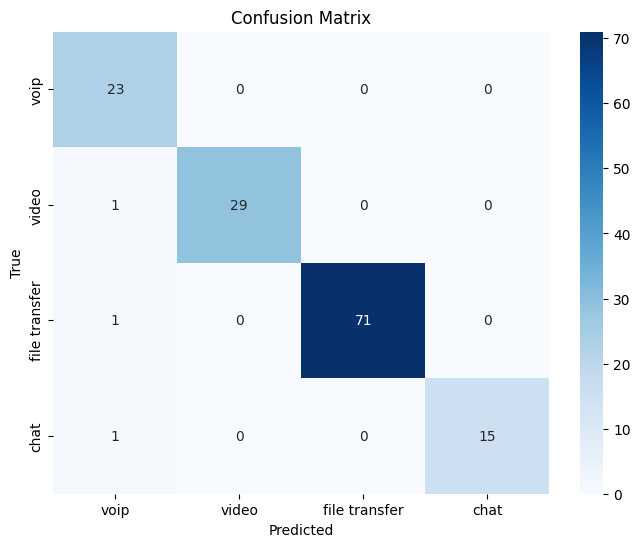

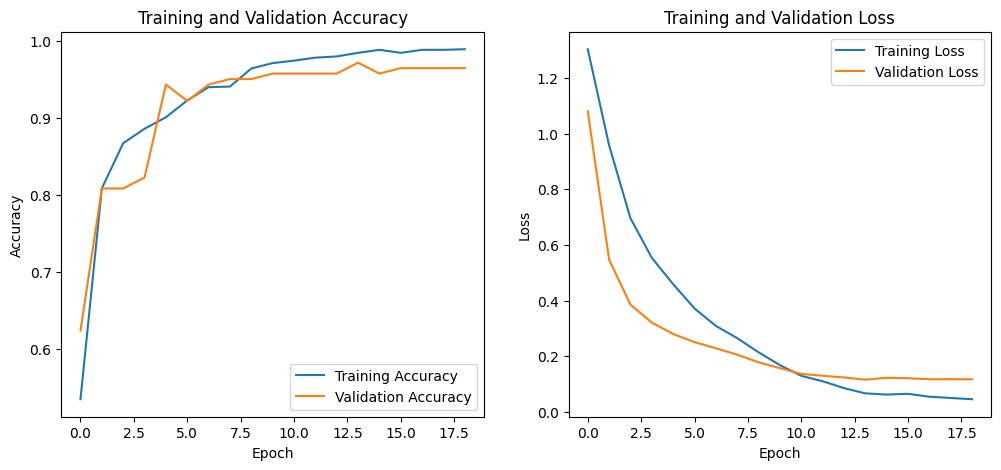

Evaluating dataset: _win60_overlap25 from directory: /kaggle/input/vpn-non-vpn-iscx-2016-npy
Conv Layers: [(10, (10, 10), 5), (20, (10, 10), 5)]
Dropout Rates: [0.25, 0.5]
Dense Layers: [64]
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 182s 18s/step - accuracy: 0.4208 - loss: 1.3451 - precision_1: 0.4274 - recall_1: 0.0114 - top_2_categorical_accuracy: 0.6282 - val_accuracy: 0.7800 - val_loss: 0.9859 - val_precision_1: 1.0000 - val_recall_1: 0.2933 - val_top_2_categorical_accuracy: 0.8400 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 175s 18s/step - accuracy: 0.7701 - loss: 1.0171 - precision_1: 0.9687 - recall_1: 0.4410 - top_2_categorical_accuracy: 0.9225 - val_accuracy: 0.8400 - val_loss: 0.5707 - val_precision_1: 0.9890 - val_recall_1: 0.6000 - val_top_2_categorical_accuracy: 0.9667 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 176s 18s/step - accuracy: 0.8634 - loss: 0.7844 - precision_1: 0.9936 - recall_1: 0.6948 - top_2_categorical_accuracy: 0.9612 - val_accuracy: 0.9067 - val_loss: 0.4716 - val_precision_1: 0.9804 - val_recall_1: 0.6667 - val_top_2_categorical_accuracy: 0.9667 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 186s 19s/step

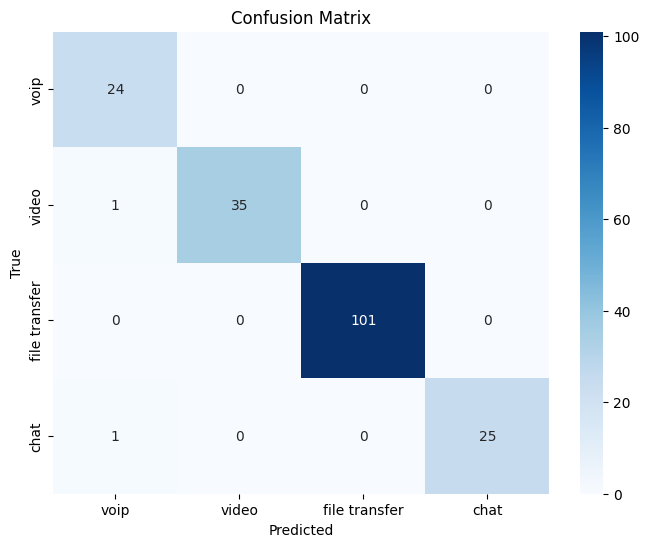

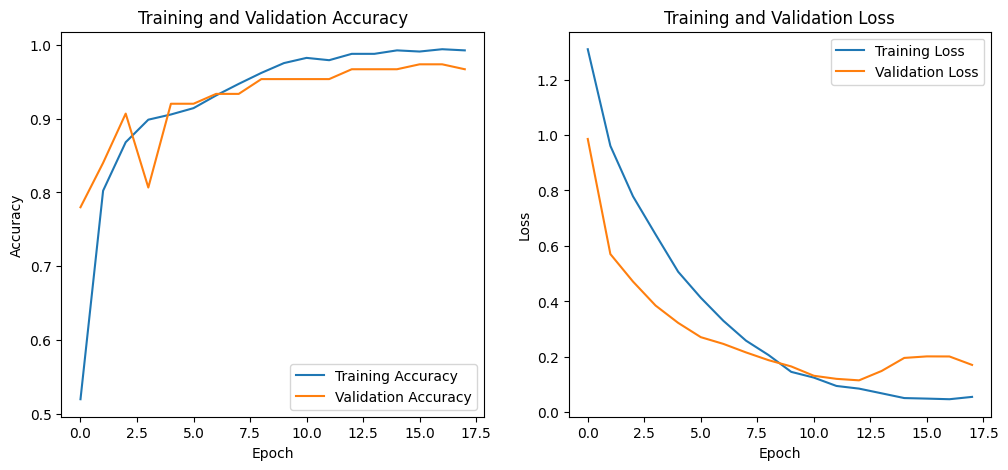

Evaluating dataset: _win60_overlap75 from directory: /kaggle/input/vpn-non-vpn-iscx-2016-npy/win60_overlap75
Conv Layers: [(10, (10, 10), 5), (20, (10, 10), 5)]
Dropout Rates: [0.25, 0.5]
Dense Layers: [64]
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 182s 18s/step - accuracy: 0.2940 - loss: 1.3792 - precision_2: 0.4545 - recall_2: 0.0045 - top_2_categorical_accuracy: 0.4967 - val_accuracy: 0.7763 - val_loss: 1.2117 - val_precision_2: 1.0000 - val_recall_2: 0.0828 - val_top_2_categorical_accuracy: 0.8434 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 178s 18s/step - accuracy: 0.7884 - loss: 1.0611 - precision_2: 0.9976 - recall_2: 0.1898 - top_2_categorical_accuracy: 0.8850 - val_accuracy: 0.8367 - val_loss: 0.6331 - val_precision_2: 1.0000 - val_recall_2: 0.5749 - val_top_2_categorical_accuracy: 0.9732 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 179s 18s/step - accuracy: 0.8397 - loss: 0.7373 - precision_2: 1.0000 - recall_2: 0.6318 - top_2_categorical_accuracy: 0.9378 - val_accuracy: 0.8456 - val_loss: 0.3770 - val_precision_2: 0.9970 - val_recall_2: 0.7383 - val_top_2_categorical_accuracy: 0.9709 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 190s 18s/step

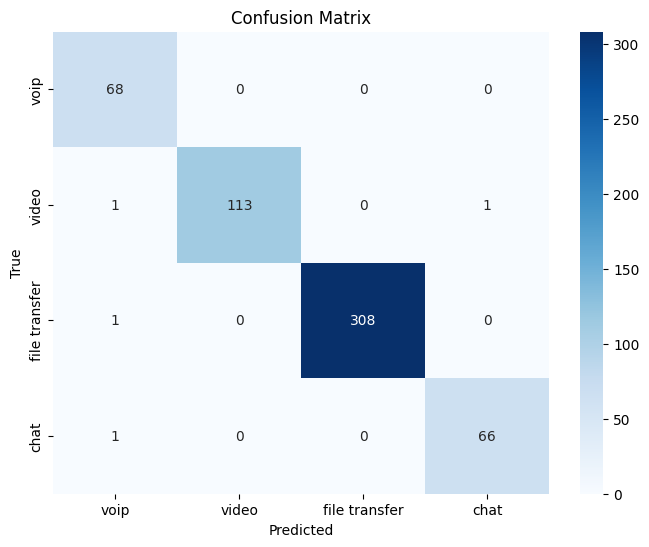

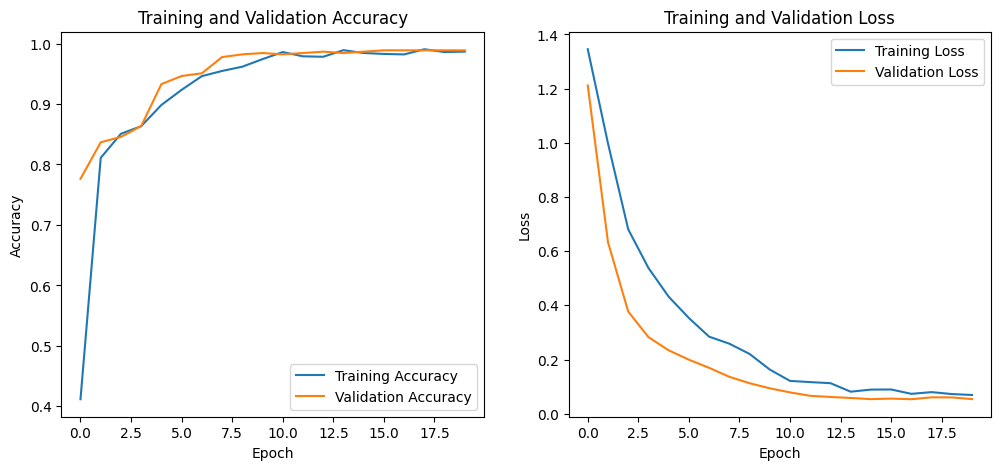

Evaluating dataset: _win30 from directory: /kaggle/input/vpn-non-vpn-iscx-2016-npy/win30
Conv Layers: [(10, (10, 10), 5), (20, (10, 10), 5)]
Dropout Rates: [0.25, 0.5]
Dense Layers: [64]
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 188s 18s/step - accuracy: 0.4453 - loss: 1.3579 - precision_3: 0.2727 - recall_3: 0.0034 - top_2_categorical_accuracy: 0.7097 - val_accuracy: 0.7742 - val_loss: 1.0039 - val_precision_3: 1.0000 - val_recall_3: 0.1797 - val_top_2_categorical_accuracy: 0.9355 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 176s 18s/step - accuracy: 0.7262 - loss: 1.0966 - precision_3: 0.8633 - recall_3: 0.3628 - top_2_categorical_accuracy: 0.9283 - val_accuracy: 0.8756 - val_loss: 0.5143 - val_precision_3: 1.0000 - val_recall_3: 0.6912 - val_top_2_categorical_accuracy: 0.9724 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 172s 17s/step - accuracy: 0.8406 - loss: 0.8233 - precision_3: 0.9884 - recall_3: 0.6505 - top_2_categorical_accuracy: 0.9628 - val_accuracy: 0.8756 - val_loss: 0.3337 - val_precision_3: 1.0000 - val_recall_3: 0.7419 - val_top_2_categorical_accuracy: 0.9770 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 173s 17s/step

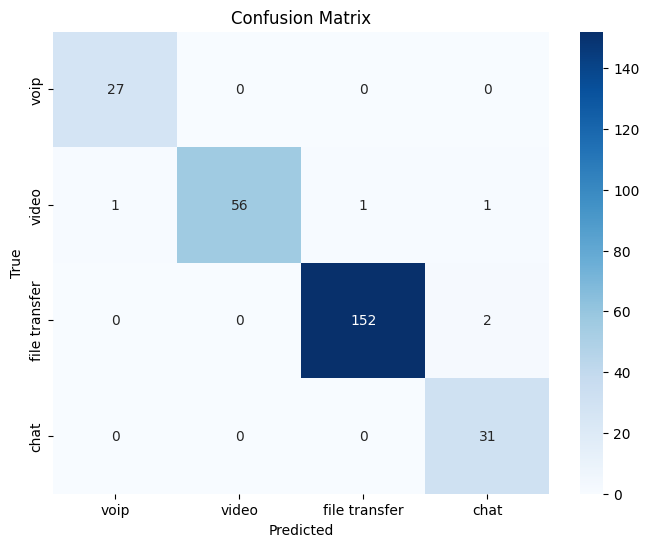

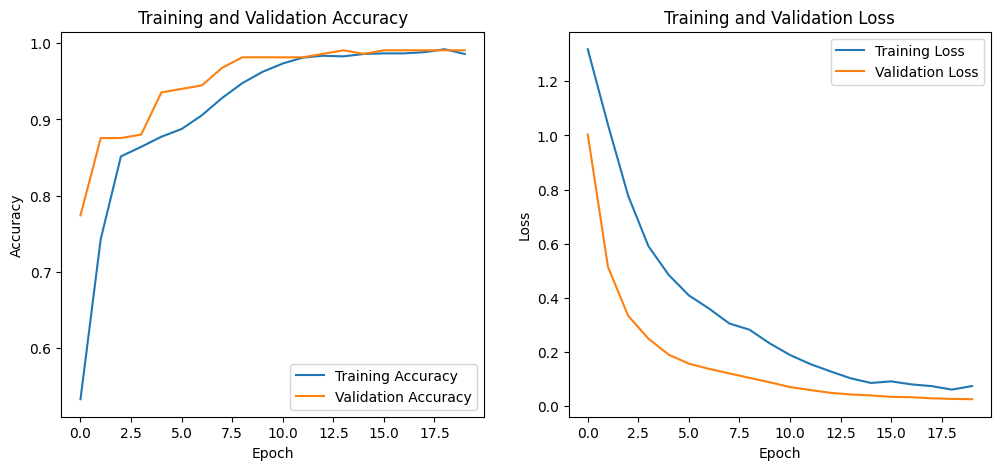

Evaluating dataset: _win10 from directory: /kaggle/input/vpn-non-vpn-iscx-2016-npy/win10
Conv Layers: [(10, (10, 10), 5), (20, (10, 10), 5)]
Dropout Rates: [0.25, 0.5]
Dense Layers: [64]
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 187s 19s/step - accuracy: 0.2625 - loss: 1.3772 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - top_2_categorical_accuracy: 0.6783 - val_accuracy: 0.2024 - val_loss: 1.3134 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_top_2_categorical_accuracy: 0.9292 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 187s 19s/step - accuracy: 0.3298 - loss: 1.2974 - precision_4: 0.5938 - recall_4: 0.0295 - top_2_categorical_accuracy: 0.8819 - val_accuracy: 0.5750 - val_loss: 0.9396 - val_precision_4: 0.7595 - val_recall_4: 0.1012 - val_top_2_categorical_accuracy: 0.9831 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 181s 18s/step - accuracy: 0.6222 - loss: 1.0851 - precision_4: 0.6998 - recall_4: 0.3975 - top_2_categorical_accuracy: 0.9682 - val_accuracy: 0.9039 - val_loss: 0.4981 - val_precision_4: 1.0000 - val_recall_4: 0.7487 - val_top_2_categorical_accuracy: 0.9781 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━

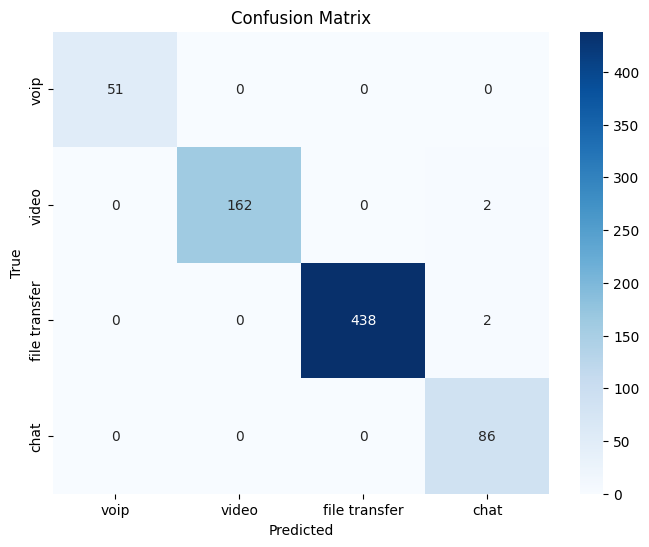

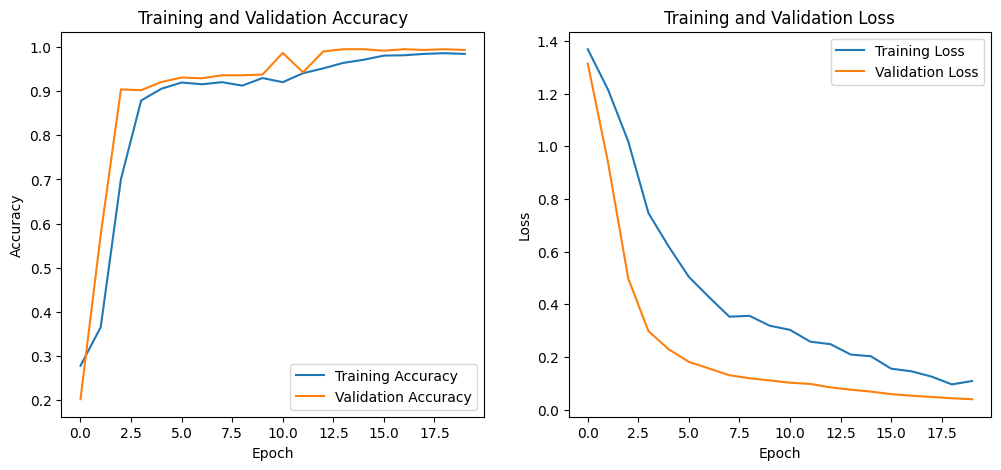

In [10]:
# Evaluate datasets
results_1 = evaluate_datasets(
    dataset_info=dataset_info,
    height=height,
    width=width,
    channels=channels,
    class_names=class_names,
    conv_layers= [(10, (10, 10), 5), (20, (10, 10), 5)],
    dropout_rates=[0.25, 0.5],
    dense_layers=[64],
    batch_size=batch_size,
    epochs=epochs,
    samples_per_epoch=samples_per_epoch,
    use_class_weights=True
)